In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Solving the Schrodinger equation ##

Here we give an example of numerically solving the Schrodinger equation using [Numerov's method](https://en.wikipedia.org/wiki/Numerov%27s_method), which is tailored to linear equations with no first derivative.  Numerov's method can be derived by Taylor series and central finite difference (see the end of the notebook).

We'll do the square well, which is something we can do entirely without numerical methods, just because it is so familiar.  We will use "natural" units ($\hbar=m=1$) throughout.

To begin we rewrite the "standard" (time-independent) Schrodinger equation in one dimension
$$
  -\frac{\hbar^2}{2m}\frac{d^2\Psi}{dx^2} + V(x)\Psi = E\Psi
  \quad\to\quad
  \frac{d^2\Psi}{dx^2} + k_{\rm eff}^2\Psi = 0
$$
with $k_{\rm eff}^2=2[E-V(x)]$.  Once we discretize $\Psi(x)$ onto a grid, $x_n=x_0+nh$, with spacing $h$ Numerov's method becomes:
$$
  \Psi_{n} = \frac{2(1-[5/12]h^2k_{n-1}^2)\Psi_{n-1}-(1+[1/12]h^2k_{n-2}^2)\Psi_{n-2}}{1+[1/12]h^2k_n^2}
$$
with $\Psi_n=\Psi(x_n)$.  The algorithm starts from $\Psi_0$ and $\Psi_1$ and moving to higher $x$.  If we make our well run from $x=-1$ to $x=1$ then $V(x)=0$ within the problem domain and we need $\Psi(x=-1)=\Psi(x=+1)=0$.

(Though we won't implement it here, there is a "matrix" version of the Numerov method which is well suited to boundary value problems of the kind we want here.  It involves writing the above equation for $\Psi_n$ as a matrix equation for $\vec{\Psi}$ and finding its eigenvalues. )

In [2]:
# Define the problem space:
Lside = 2.0   # The length of the computation space, in natural units.
N     = 2048  # The size of the grid.
TOL   = 1e-4  # A numerical tolerance for convergence.

# Set up some "helper" functions.
def V(x):
    """Our potential -- a square well centered on zero."""
    return( 0 )

def posn(n):
    """Convert from grid position to x coordinate."""
    return( -Lside/2.0 + n*Lside/N )

hh = posn(1) - posn(0)
h2 = hh**2

def keff2(E,x):
    return( 2*(E-V(x)) )

def psiup(n,E,psi1,psi2):
    """Compute Psi_n using the Numerov algorithm given Psi_{n-1}
    and Psi_{n-2}.  In Numerov the second derivative is approximated
    by finite difference but the Psi^{(4)} correction term is included
    using the 2nd derivative of the Schrodinger equation.
    This is coded very non-Pythonically, and it computes the k_n
    way more often than necessary (they should be computed once and
    stored in an array) but hopefully it is clear."""
    t    = 1./12.0
    knm0 = keff2(E,posn(n-0))
    knm1 = keff2(E,posn(n-1))
    knm2 = keff2(E,posn(n-2))
    psi  = 2*(1-5*t*h2*knm1)*psi1 - (1+t*h2*knm2)*psi2
    psi /= 1+t*h2*knm0
    return(psi)

In [3]:
# Code the Numerov solver.
def numerov_solve(E):
    """Does Numerov until convergence.  This is coded very non-Pythonically,
    but hopefully in a way that is clear."""
    psi    = np.zeros(N+1)
    psi[0] = 0.0
    psi[1] = 2e-10
    for n in range(2,N+1):
        psi[n] = psiup(n,E,psi[n-1],psi[n-2])
    return( (np.max(psi),psi) )

Note if we just pick a "random" value of $E$ the solution won't obey our boundary conditions ($\Psi$ has to vanish as $|x|\to\infty$), so we would adjust $E$ until we can find such a solution:

E=  1.2000e+00, Psi_max=  1.3220e-07, Psi[-1]=  4.3193e-02 Psi_max
E=  1.3000e+00, Psi_max=  1.2701e-07, Psi[-1]= -8.3214e-02 Psi_max
E=  1.2500e+00, Psi_max=  1.2953e-07, Psi[-1]= -2.0684e-02 Psi_max
E=  1.2250e+00, Psi_max=  1.3084e-07, Psi[-1]=  1.1097e-02 Psi_max
E=  1.2375e+00, Psi_max=  1.3018e-07, Psi[-1]= -4.8339e-03 Psi_max
E=  1.2313e+00, Psi_max=  1.3051e-07, Psi[-1]=  3.1217e-03 Psi_max
E=  1.2344e+00, Psi_max=  1.3034e-07, Psi[-1]= -8.5862e-04 Psi_max
E=  1.2328e+00, Psi_max=  1.3043e-07, Psi[-1]=  1.1309e-03 Psi_max
E=  1.2336e+00, Psi_max=  1.3039e-07, Psi[-1]=  1.3599e-04 Psi_max
E=  1.2340e+00, Psi_max=  1.3036e-07, Psi[-1]= -3.6136e-04 Psi_max
E=  1.2338e+00, Psi_max=  1.3038e-07, Psi[-1]= -1.1270e-04 Psi_max
E=  1.2337e+00, Psi_max=  1.3038e-07, Psi[-1]=  1.1642e-05 Psi_max
Exact energy of ground state is   1.2337e+00


Text(0, 0.5, '$\\Psi/\\Psi_{\\rm max}$')

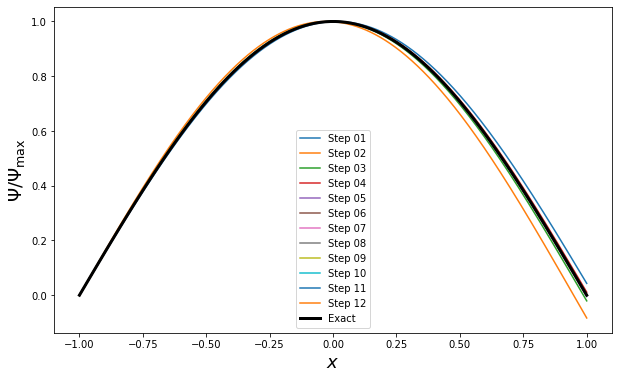

In [4]:
# Now do an example of finding a solution for the energy eigenvalue
# using a simple bisection algorithm.
Emin,Emax = 1.0,1.4  # We know the energy is in this range (pi^2/8).
keepgoing = True
istep     = 1
maxstep   = 100
fig,ax    = plt.subplots(1,1,figsize=(10,6))
while keepgoing:
    E          = 0.5*(Emin+Emax)
    psimax,psi = numerov_solve(E)
    print("E={:12.4e}, Psi_max={:12.4e}, Psi[-1]={:12.4e} Psi_max".\
          format(E,psimax,psi[-1]/psimax))
    ax.plot(posn(np.arange(psi.size)),psi/np.max(psi),label="Step {:02d}".format(istep))
    if psi[-1]<0:
        Emax = E
    elif psi[-1]>0:
        Emin = E
    istep    += 1
    keepgoing = (np.abs(psi[-1])>TOL*psimax)&(istep<maxstep)
#
# We can also plot the exact answer and energy eigenvalue:
#
print("Exact energy of ground state is {:12.4e}".format(np.pi**2/8.))
xx = np.linspace(-1,1,100)
ax.plot(xx,np.cos(np.pi/2*xx),'k-',lw=3,label='Exact')
ax.legend()
ax.set_xlabel(r'$x$',fontsize=18)
ax.set_ylabel(r'$\Psi/\Psi_{\rm max}$',fontsize=18)

### Harmonic oscilator ###

Now let's modify the potential to do the harmonic oscillator (what else?!).  In this case we'll do a slightly larger domain since we need our Gaussian to fall to zero at large distances.

In [5]:
# Define the problem space:
Lside = 10.0  # The length of the computation space, in natural units.
N     = 4096  # The size of the grid.
TOL   = 1e-4  # A numerical tolerance for convergence.

# Set up some "helper" functions.
def V(x):
    """Our potential -- a harmonic oscillator centered on zero."""
    return( 0.5*x**2 )

def posn(n):
    """Convert from grid position to x coordinate."""
    return( -Lside/2.0 + n*Lside/N )

hh = posn(1) - posn(0)
h2 = hh**2

def keff2(E,x):
    return( 2*(E-V(x)) )

def psiup(n,E,psi1,psi2):
    """Compute Psi_n using the Numerov algorithm given Psi_{n-1}
    and Psi_{n-2}.  In Numerov the second derivative is approximated
    by finite difference but the Psi^{(4)} correction term is included
    using the 2nd derivative of the Schrodinger equation.
    This is coded very non-Pythonically, and it computes the k_n
    way more often than necessary (they should be computed once and
    stored in an array) but hopefully it is clear."""
    t    = 1./12.0
    knm0 = keff2(E,posn(n-0))
    knm1 = keff2(E,posn(n-1))
    knm2 = keff2(E,posn(n-2))
    psi  = 2*(1-5*t*h2*knm1)*psi1 - (1+t*h2*knm2)*psi2
    psi /= 1+t*h2*knm0
    return(psi)

E=  5.5000e-01, Psi_max=  1.9799e-03, Psi[-1]= -4.4059e+03 Psi_max
E=  4.7500e-01, Psi_max=  6.0877e+00, Psi[-1]=  1.0000e+00 Psi_max
E=  5.1250e-01, Psi_max=  2.1747e-03, Psi[-1]= -1.1861e+03 Psi_max
E=  4.9375e-01, Psi_max=  1.4014e+00, Psi[-1]=  1.0000e+00 Psi_max
E=  5.0313e-01, Psi_max=  2.2272e-03, Psi[-1]= -3.0183e+02 Psi_max
E=  4.9844e-01, Psi_max=  3.4317e-01, Psi[-1]=  1.0000e+00 Psi_max
E=  5.0078e-01, Psi_max=  2.2406e-03, Psi[-1]= -7.5790e+01 Psi_max
E=  4.9961e-01, Psi_max=  8.5349e-02, Psi[-1]=  1.0000e+00 Psi_max
E=  5.0020e-01, Psi_max=  2.2440e-03, Psi[-1]= -1.8968e+01 Psi_max
E=  4.9990e-01, Psi_max=  2.1310e-02, Psi[-1]=  1.0000e+00 Psi_max
E=  5.0005e-01, Psi_max=  2.2448e-03, Psi[-1]= -4.7434e+00 Psi_max
E=  4.9998e-01, Psi_max=  5.3257e-03, Psi[-1]=  1.0000e+00 Psi_max
E=  5.0001e-01, Psi_max=  2.2450e-03, Psi[-1]= -1.1859e+00 Psi_max
E=  4.9999e-01, Psi_max=  2.2451e-03, Psi[-1]=  5.9299e-01 Psi_max
E=  5.0000e-01, Psi_max=  2.2451e-03, Psi[-1]= -2.9648e-01 Psi

Text(0, 0.5, '$\\Psi/\\Psi_{\\rm max}$')

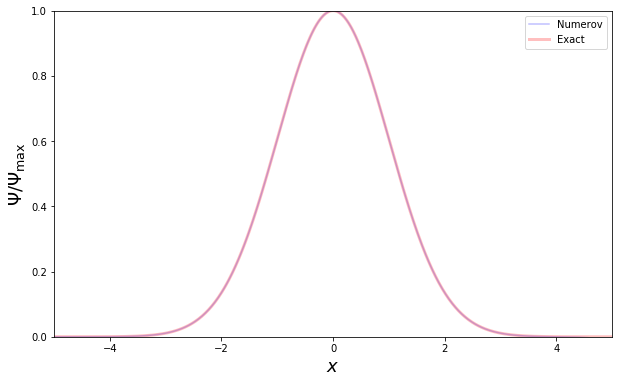

In [16]:
# Again find E using a simple bisection algorithm.
Emin,Emax = 0.4,0.7  # We know the energy is in this range (=1/2).
keepgoing = True
istep     = 1
maxstep   = 20
fig,ax    = plt.subplots(1,1,figsize=(10,6))
while keepgoing:
    E          = 0.5*(Emin+Emax)
    psimax,psi = numerov_solve(E)
    print("E={:12.4e}, Psi_max={:12.4e}, Psi[-1]={:12.4e} Psi_max".\
          format(E,psimax,psi[-1]/psimax))
    if psi[-1]<0:
        Emax = E
    elif psi[-1]>0:
        Emin = E
    istep    += 1
    keepgoing = (np.abs(psi[-1])>TOL*psimax)&(istep<maxstep)
#
# We can also plot the exact answer and energy eigenvalue:
#
print("Exact energy of ground state is {:12.4e}".format(0.5))
ax.plot(posn(np.arange(psi.size)),psi/np.max(psi),'b-',alpha=0.25,label="Numerov")
xx = np.linspace(-10,10,1000)
ax.plot(xx,np.exp(-0.5*xx**2),'r-',lw=3,alpha=0.25,label='Exact')
ax.legend()
ax.set_xlim(-Lside/2,Lside/2)
ax.set_ylim(0,1)
ax.set_xlabel(r'$x$',fontsize=18)
ax.set_ylabel(r'$\Psi/\Psi_{\rm max}$',fontsize=18)

### Numerov derivation ###

Here we briefly recap the derivation onf the Numerov method in our context just for completeness.  Since this is a well-known algorithm that you can find described in many places, I'll be a bit sketchy in how the derivation goes.

As mentioned above one begins by Taylor expanding $\Psi$ keeping terms to 4th order:
$$
  \Psi(x+h) \approx \Psi(x) + h\Psi^{(1)}(x) + \frac{h^2}{2}\Psi^{(2)}(x)
  + \frac{h^3}{6}\Psi^{(3)}(x) + \frac{h^4}{24}\Psi^{(4)}(x) + \cdots
$$
Using central differences the $d^2\Psi/dx^2$ term can be approximated as
$$
  \frac{d^2\Psi}{dx^2} = \Psi^{(2)}(x) \approx \frac{\Psi(x+h)+\Psi(x-h)-2\Psi(x)}{h^2}
  -\frac{h^2}{12}\Psi^{(4)}(x) + \cdots
$$
Now multiply our Schrodinger equation by $1+(h^2/12)d^2/dx^2$:
$$
  \Psi^{(2)} + \frac{h^2}{12}\Psi^{(4)} = -k^2\Psi - \frac{h^2}{12}\frac{d^2}{dx^2}
  \left[ k^2\Psi\right] + \cdots
$$
Upon replacing $d^2/dx^2[k^2\Psi]$ with the central difference formula and rearranging we get the Numerov algorithm.

This turns out to be an $\mathcal{O}(h^4)$ method, similar to 4th order Runge-Kutta.